## 0. Get image for visualize function testing

In [100]:
import cv2
import os
import random
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

In [101]:
# Create image sample for augmentation function testing
video_path = "dataset/videos/D0014.mp4"
image_dir = "dataset/visualization"
os.makedirs(image_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)

expected_second = 2
fps = cap.get(cv2.CAP_PROP_FPS)
frame_number = int(expected_second * fps)

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

ret, frame = cap.read()
if ret:
    # Export frame into image
    cv2.imwrite("dataset/visualization/D0014_example.jpg", frame)
    print("Saved image successfully!")
else:
    print("Cannot read the frame.")

Saved image successfully!


In [102]:
# Using all hand landmarks (https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker)
N_HAND_LANDMARKS = 21
# Using upper body landmarks only without hand landmarks (https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker)
UPPER_BODY_CONNECTIONS = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
    10, 11, 12, 13, 14, 15, 16, 23, 24
]
N_POSE_LANDMARKS = len(UPPER_BODY_CONNECTIONS)
# Total number of landmarks for upper body and two hands (left + right)
N_LANDMARKS = N_POSE_LANDMARKS + N_HAND_LANDMARKS*2


def extract_keypoints(results):
    """Extract all keypoints from video frame."""
    
    # upper body keypoints
    pose = np.zeros((N_POSE_LANDMARKS, 3))
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        for idx, i in enumerate(UPPER_BODY_CONNECTIONS):
            if i < len(landmarks):
                res = landmarks[i]
                pose[idx] = [res.x, res.y, res.z]
    pose = np.array(pose).flatten()
    # left hand and right hand keypoints
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(N_HAND_LANDMARKS*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(N_HAND_LANDMARKS*3)
    
    return np.concatenate([pose, lh, rh])

I0000 00:00:1760787558.838434  425181 gl_context.cc:369] GL version: 2.1 (2.1 INTEL-20.7.3), renderer: Intel(R) Iris(TM) Plus Graphics 640
W0000 00:00:1760787559.285711  543844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760787559.416852  543844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760787559.435778  543844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760787559.437345  543846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760787559.441178  543843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature in

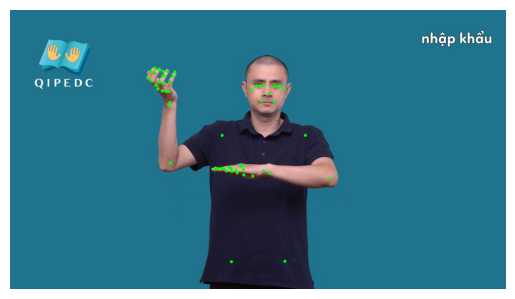

In [103]:
# Load image
image = cv2.imread("dataset/visualization/D0014_example.jpg")
image_height, image_width, _ = image.shape

# Convert the BGR image to RGB before processing.
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# keypoint extraction
mp_holistic = mp.solutions.holistic
with mp_holistic.Holistic(static_image_mode=True) as holistic:
    results = holistic.process(image_rgb)
keypoints = extract_keypoints(results)
np.save(os.path.join("dataset/visualization/", "D0014_keypoints.npy"), keypoints)

org_keypoints = np.load("dataset/visualization/D0014_keypoints.npy")
for (x, y, _) in org_keypoints.reshape(N_LANDMARKS, 3):
    if x != 0 and y != 0:
        px = int(x * image_width)
        py = int(y * image_height)
        cv2.circle(image, (px, py), 4, (0, 255, 0), -1)

plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [114]:
image_path = "dataset/visualization/D0014_example.jpg"
def visualize(image_path, org_keypoints, transformed_keypoints):
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape
    for (x, y, _) in org_keypoints.reshape(N_LANDMARKS, 3):
        if x != 0 and y != 0:
            px = int(x * image_width)
            py = int(y * image_height)
            cv2.circle(image, (px, py), 4, (0, 255, 0), -1)
            
    for (x, y, _) in transformed_keypoints.reshape(N_LANDMARKS, 3):
        if x != 0 and y != 0:
            px = int(x * image_width)
            py = int(y * image_height)
            cv2.circle(image, (px, py), 4, (0, 0, 255), -1)

    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## 1. Augmentation Functions

### 1.1 Translation Transformation

In [ ]:
def translate(flat_keypoints, x_range = (-0.05, 0.05), y_range= (-0.05, 0.05), n_landmarks=None):
    translated_keypoints = []
    if flat_keypoints is None:
        return translated_keypoints
    
    # Generate random displacement vectors
    dx = random.uniform(*x_range)
    dy = random.uniform(*y_range)
    
    try:
        keypoints = flat_keypoints.copy().reshape(n_landmarks, 3)
    except ValueError:
        return translated_keypoints
    
    # Identify valid keypoints (non-zero rows)
    valid_mask = np.any(keypoints != 0, axis=1)
    
    # Apply translation to valid keypoints
    keypoints[valid_mask, 0] += dx                 # x_new = x + b
    keypoints[valid_mask, 1] += dy                 # y_new = y + b
    
    translated_flat_seq = keypoints.flatten()
    if np.isnan(translated_flat_seq).any() or np.isinf(translated_flat_seq).any():
        return translated_keypoints
    else:
        return np.array(translated_flat_seq)

In [ ]:
org_keypoints = np.load("dataset/visualization/D0014_keypoints.npy")
translated_keypoints = translate(org_keypoints, n_landmarks=N_LANDMARKS)
print(translated_keypoints.shape, org_keypoints.shape)
print(org_keypoints[0], translated_keypoints[0])

(183,) (183,)


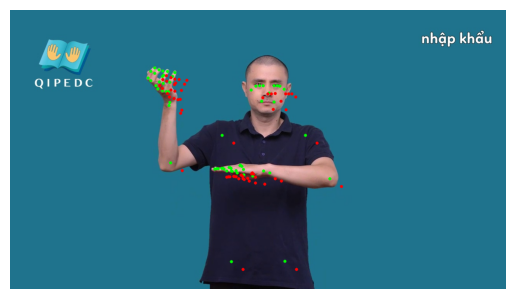

In [ ]:
# Load image
image = cv2.imread("dataset/visualization/D0014_example.jpg")
image_height, image_width, _ = image.shape

for (x, y, _) in org_keypoints.reshape(N_LANDMARKS, 3):
    if x != 0 and y != 0:
        px = int(x * image_width)
        py = int(y * image_height)
        cv2.circle(image, (px, py), 4, (0, 255, 0), -1)
        
for (x, y, _) in translated_keypoints.reshape(N_LANDMARKS, 3):
    if x != 0 and y != 0:
        px = int(x * image_width)
        py = int(y * image_height)
        cv2.circle(image, (px, py), 4, (0, 0, 255), -1)

plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 1.2 Scaling Transformation

In [132]:
def scale(flat_keypoints, scale_range=(0.8, 1.2), n_landmarks=None):
    if flat_keypoints is None:
        return flat_keypoints
    
    scale_factor = random.uniform(*scale_range)
    try:
        keypoints = flat_keypoints.copy().reshape(n_landmarks, 3)
    except ValueError:
        return translated_keypoints
    
    # identify valid keypoints (x,y != 0)
    valid_mask = np.any(keypoints[:, :2] != 0, axis=1)
    if not np.any(valid_mask):
        return flat_keypoints
    
    # compute center point
    valid_xy = keypoints[valid_mask, :2]
    center_xy = np.median(valid_xy, axis=0)
    
    # apply scaling around the center
    keypoints[valid_mask, :2] = center_xy + (valid_xy - center_xy) * scale_factor

    # clip to [0,1]
    keypoints[valid_mask, :2] = np.clip(keypoints[valid_mask, :2], 0.0, 1.0)

    return np.array(keypoints.flatten())

(183,) (183,)
0.5223698019981384 0.5352840921718874


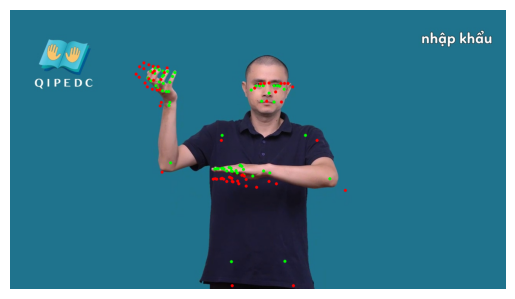

In [140]:
org_keypoints = np.load("dataset/visualization/D0014_keypoints.npy")
scaled_keypoints = scale(org_keypoints, scale_range=(0.5, 1.5), n_landmarks=N_LANDMARKS)
print(scaled_keypoints.shape, org_keypoints.shape)
print(org_keypoints[0], scaled_keypoints[0])
visualize(image_path, org_keypoints, scaled_keypoints)

### 1.3 Rotation Transformation